# KNN Classifier using features that matter

**Goal**: Build a KNN classifier that uses only the features that matter, and gives more weight to the most useful ones.
**Dataset**: sklearn.datasets.load_breast_cancer (binary classification; 30 numeric features).

## Plan (broad → focused):
1. **Baseline with all features** (Pipeline: StandardScaler → KNeighborsClassifier).
Purpose: establish a reference accuracy.
2. **Filter method**: rank features by Mutual Information (MI) with the target, then test top-k subsets via cross-validation.
Purpose: fast, model-agnostic signal of relevance.
3. **Wrapper method**: Sequential Forward Selection (SFS) wrapped around the KNN pipeline.
Purpose: pick a subset that optimizes CV accuracy for the actual model.
4. **Model-agnostic importance**: Permutation importance on a validation set using the chosen subset.
Purpose: sanity-check and quantify which selected features the model truly uses.
5. **Weighted KNN**: convert permutation importances into per-feature weights and use weighted Minkowski distance (metric="wminkowski") so important features count more.
Purpose: bake “feature importance” directly into the distance metric.
6. **Finalization**: pick (unweighted vs weighted) by validation accuracy, refit on train+val, and evaluate on the test set.
Why this order? We start broad to understand signals cheaply (filter), then let the model choose (wrapper), then verify (permutation), then use that knowledge (weights), and finally lock it in (test).

# Data split (60/20/20, stratified)
**What happens:**
- You split into train/val/test with class stratification so each split mirrors the class balance.
- Train is where feature selection and model fitting happen; validation is for model selection (e.g., whether weights help); test is held out until the end.
  
**Why:**
- Prevents information leakage and gives an unbiased final estimate.

**Check:**
- Confirm similar class ratios across splits; small variance is normal.
- Keep the test set completely untouched until the final step.

In [3]:
# KNN classification with feature understanding, selection, and weighting
# --------------------------------------------------------------
# Requires: scikit-learn, numpy, pandas, matplotlib
# --------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import mutual_info_classif, SequentialFeatureSelector
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42

# --- Utilities -------------------------------------------------

def save_or_show(fig, filename=None):
    """
    Saves the figure to /mnt/data/knn_feature_selection_figs (if filename given)
    and tries to show it as well. If show() fails (e.g., headless), the file is still saved.
    """
    if filename is not None:
        out_dir = os.path.join(os.getcwd(), "knn_feature_selection_figs")
        os.makedirs(out_dir, exist_ok=True)
        path = os.path.join(out_dir, filename)
        fig.savefig(path, bbox_inches="tight")
        print(f"[saved] {path}")
    try:
        plt.show()
    except Exception:
        pass
    plt.close(fig)

def cv_score_with_features(X, y, feature_list, n_neighbors=5, cv=None):
    """Cross-validated accuracy using a standard KNN pipeline on a given feature subset."""
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=n_neighbors))
    ])
    scores = cross_val_score(pipe, X[feature_list], y, cv=cv, scoring="accuracy")
    return scores.mean(), scores

# --- 1) Load & split ------------------------------------------

data = load_breast_cancer()
X_full = pd.DataFrame(data.data, columns=data.feature_names)
y_full = pd.Series(data.target, name="target")

# 60% train, 20% val, 20% test (stratified)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=RANDOM_STATE
)
print("Shapes -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

Shapes -> train: (341, 30) val: (114, 30) test: (114, 30)


## Baseline (all features → StandardScaler → KNN(k=5))

**What happens:**
- **StandardScaler normalizes each feature to zero mean** / unit variance within each CV fold (pipeline avoids leakage).
- KNN uses Euclidean distance (p=2) with k=5.

**Why:**
- Establish a reference accuracy using everything, with proper scaling → **KNN is distance-based; scale matters a lot**.

**Check:**
- Look at fold-wise scores. High variance across folds can hint at sensitivity to sample composition or feature noise.
- Optionally try a quick k-grid (e.g., 3–25) as a sanity check.

In [4]:

# --- 2) Baseline with all features -----------------------------

baseline_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
baseline_cv = cross_val_score(baseline_pipe, X_train, y_train, cv=cv, scoring="accuracy")
print(f"\nBaseline (all features) CV accuracy: mean={baseline_cv.mean():.4f}, scores={np.round(baseline_cv, 4)}")


Baseline (all features) CV accuracy: mean=0.9648, scores=[0.971  0.9118 1.     0.9706 0.9706]


## Filter: Mutual Information (MI) ranking + top-k evaluation

> * MI measures **how much knowing a feature reduces uncertainty about the target**.
> * Unlike correlation, MI can capture non-linear relationships.

**In practice:**
- Filter methods like MI are often used for a first cut:
  - Remove clearly irrelevant/noisy features.
  - Reduce dimensionality before more expensive wrapper methods.

**What happens:**
- **For each feature individually**, compute its mutual information with the target.
- You MinMax-scale only for MI (makes neighbor-based MI more stable across features).
- `mutual_info_classif` **estimates how much information each single feature carries about the label** (non-linear, model-agnostic).
- Then you test top-k subsets (k=1..15) using the actual KNN pipeline and CV.

**Why:**
- Fast signal of marginal relevance. The top-k CV curve shows how much you gain by adding the next best MI feature.

**Check:**
- Expect diminishing returns or a small “elbow”.
- MI is univariate—redundant features can look strong individually but add little together.


Top 10 features by Mutual Information:
worst perimeter         0.473153
worst radius            0.465186
mean concave points     0.460651
worst area              0.452752
worst concave points    0.451801
mean perimeter          0.409273
mean concavity          0.352609
mean radius             0.337765
mean area               0.336319
area error              0.328567
dtype: float64


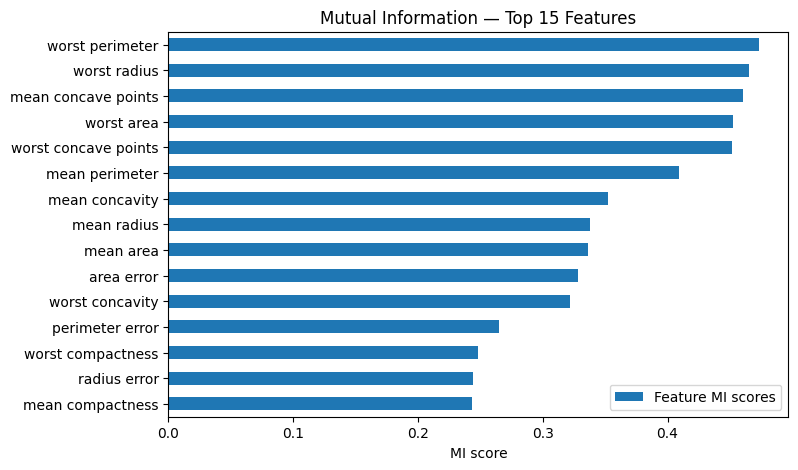


MI selection → best k=11 (CV acc=0.9561)


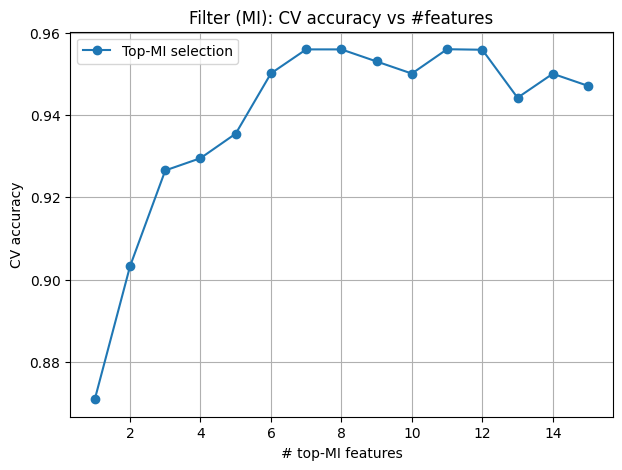

In [5]:
# --- 3) FILTER: Mutual Information ranking --------------------

# MI is neighbor-based; MinMax scaling helps it compare distances fairly
mm = MinMaxScaler()
X_train_mm = mm.fit_transform(X_train)
mi = mutual_info_classif(X_train_mm, y_train, random_state=RANDOM_STATE)
mi_series = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)
print("\nTop 10 features by Mutual Information:")
print(mi_series.head(10))

# Plot top-15 MI features
fig = plt.figure(figsize=(8, 5))
mi_series.iloc[:15][::-1].plot(kind="barh")
plt.title("Mutual Information — Top 15 Features")
plt.xlabel("MI score")
plt.legend(["Feature MI scores"])
save_or_show(fig)

# Evaluate top-k by MI (1..15)
k_grid = list(range(1, 16))
mi_cv_means = []
for k in k_grid:
    feats = list(mi_series.index[:k])
    mean_acc, _ = cv_score_with_features(X_train, y_train, feats, n_neighbors=5, cv=cv)
    mi_cv_means.append(mean_acc)

best_k_mi = k_grid[int(np.argmax(mi_cv_means))]
best_mi_feats = list(mi_series.index[:best_k_mi])
print(f"\nMI selection → best k={best_k_mi} (CV acc={max(mi_cv_means):.4f})")
fig = plt.figure(figsize=(7, 5))
plt.plot(k_grid, mi_cv_means, marker="o")
plt.title("Filter (MI): CV accuracy vs #features")
plt.xlabel("# top-MI features")
plt.ylabel("CV accuracy")
plt.legend(["Top-MI selection"])
plt.grid(True)
save_or_show(fig)

## Wrapper: Sequential Forward Selection (SFS) around the KNN pipeline

> Unlike MI, **SFS evaluates features in the context of the model**:
> - It knows that KNN uses Euclidean distance.
> - It considers redundancy: if two features overlap, it may keep only one.
> - It can capture interactions: two features might matter only together.

**In practice**
- Wrappers like SFS give you a model-specific subset of features, usually stronger than filter methods alone.
- You get a feature set optimized for this classifier on this dataset.

**What happens:**
- **SFS starts empty and adds the feature that most improves CV accuracy** given the current set, repeating until k features.
- You run SFS for k=1..15 and keep the k that maximizes CV accuracy.

**Why:**
- Lets the model decide which features work together → **This often beats pure ranking because it considers interactions and redundancy**.

**Check:**
- The SFS curve (CV vs #features) might peak at a smaller k than MI’s.
- Selected features can differ from MI’s top list—this is expected.

In [ ]:
# --- 4) WRAPPER: Sequential Forward Selection (SFS) -----------

# Use a pipeline inside SFS so scaling happens correctly for each subset
sfs_base = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

sfs_cv_means = []
sfs_feature_sets = []
for k in k_grid:
    sfs = SequentialFeatureSelector(
        sfs_base,
        n_features_to_select=k,
        direction="forward",
        scoring="accuracy",
        cv=cv,
        n_jobs=-1
    )
    sfs.fit(X_train, y_train)
    mask = sfs.get_support()
    feats_k = list(X_train.columns[mask])
    sfs_feature_sets.append(feats_k)
    mean_acc, _ = cv_score_with_features(X_train, y_train, feats_k, n_neighbors=5, cv=cv)
    sfs_cv_means.append(mean_acc)

best_k_sfs = k_grid[int(np.argmax(sfs_cv_means))]
best_sfs_feats = sfs_feature_sets[int(np.argmax(sfs_cv_means))]
print(f"\nSFS selection → best k={best_k_sfs} (CV acc={max(sfs_cv_means):.4f})")
print("Top features (first 8 shown):", best_sfs_feats[:8], "...")

fig = plt.figure(figsize=(7, 5))
plt.plot(k_grid, sfs_cv_means, marker="o")
plt.title("Wrapper (SFS): CV accuracy vs #features")
plt.xlabel("# SFS-selected features")
plt.ylabel("CV accuracy")
plt.legend(["SFS selection"])
plt.grid(True)
save_or_show(fig)

# We'll proceed with the SFS-selected subset (usually strongest for KNN)
chosen_feats = best_sfs_feats


## Model-agnostic check: Permutation importance on the validation set

**What happens:**
- With the SFS subset fixed, you fit the pipeline on train and then **permute one feature at a time** on the validation set.
- **The drop in accuracy is the feature’s importance**. You repeat (n_repeats=30) to average out randomness.

**Why:**
- Answers: “Which of the selected features does the fitted model actually use on unseen data?”
- Also catches “passenger” features: selected by SFS but not truly needed.

**Check:**
- Importance can be near-zero or even slightly negative (noise).
- Correlated features share credit—don’t be surprised if both look modest.

In [ ]:
# --- 5) Permutation importance on validation set --------------

sfs_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])
sfs_pipe.fit(X_train[chosen_feats], y_train)
val_pred = sfs_pipe.predict(X_val[chosen_feats])
val_acc = accuracy_score(y_val, val_pred)
print(f"\nValidation accuracy (SFS subset, unweighted distance): {val_acc:.4f}")

perm = permutation_importance(
    sfs_pipe, X_val[chosen_feats], y_val,
    n_repeats=30, random_state=RANDOM_STATE, scoring="accuracy"
)
perm_series = pd.Series(perm.importances_mean, index=chosen_feats).sort_values(ascending=False)

print("\nPermutation importance (top 10):")
print(np.round(perm_series.head(10), 5))

fig = plt.figure(figsize=(8, 5))
perm_series.iloc[:min(15, len(chosen_feats))][::-1].plot(kind="barh")
plt.title("Permutation Importance on Validation")
plt.xlabel("Mean accuracy decrease when permuted")
plt.legend(["Permutation importance"])
save_or_show(fig)

## Weighted KNN (turn validation-set importances into distance weights)

**What happens:**
- You convert permutation importances into non-negative weights, normalize them to mean=1, and apply them via a custom FeatureWeightScaler.
- This scaling makes Euclidean distance behave like weighted Minkowski (big weights → larger effective distances along that feature).

**Why:**
- If validation says some features matter more, bake that into the distance metric so neighbors are found in a space aligned with importance.

**Check:**
- Compare unweighted vs weighted on the validation set. If weighted ≥ unweighted, keep weighted; otherwise stick to unweighted.
- If many importances are ~0, weighting will resemble unweighted or effectively drop those features.

In [ ]:
# --- 6) Weighted KNN via feature scaling instead of 'wminkowski' ---

from sklearn.base import BaseEstimator, TransformerMixin

class FeatureWeightScaler(BaseEstimator, TransformerMixin):
    """
    Multiplies each feature by w**(1/p), which makes standard Minkowski(p)
    equivalent to Weighted-Minkowski with weights w.
    """
    def __init__(self, w, p=2):
        self.w = np.asarray(w, dtype=float)
        self.p = p

    def fit(self, X, y=None):
        X = np.asarray(X)
        if X.shape[1] != self.w.shape[0]:
            raise ValueError(f"Weight length {self.w.shape[0]} != n_features {X.shape[1]}")
        # zero weights are allowed (feature gets ignored)
        self.scale_ = np.power(np.clip(self.w, a_min=0.0, a_max=None), 1.0 / self.p)
        return self

    def transform(self, X):
        return np.asarray(X) * self.scale_

# (same as before) turn permutation importance into weights, normalize to mean=1
imp = perm_series.reindex(chosen_feats).fillna(0.0).clip(lower=0.0)
if (imp == 0).all():
    w = np.ones(len(chosen_feats))
else:
    w = imp.values
    w = w / (w.mean() if w.mean() != 0 else 1.0)

p = 2  # Minkowski p (2 = Euclidean)
weighted_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("wscale", FeatureWeightScaler(w=w, p=p)),
    ("knn", KNeighborsClassifier(n_neighbors=5, metric="minkowski", p=p))
])

weighted_pipe.fit(X_train[chosen_feats], y_train)
val_pred_w = weighted_pipe.predict(X_val[chosen_feats])
val_acc_w = accuracy_score(y_val, val_pred_w)
print(f"Validation accuracy (SFS subset, weighted distance via scaling): {val_acc_w:.4f}")

## Finalization and test

**What happens:**
- You **choose the better variant (by validation accuracy)**, refit on train+val, and evaluate once on the test set.
- You print confusion matrix + classification report for class-wise insight.

**Why:**
- Avoid overfitting to validation by training on all non-test data; test once for an honest estimate.

**Check:**
- If test drops notably vs CV/val, suspect high variance, small sample effects, or selection too tightly tuned to val.
- Inspect per-class precision/recall—KNN can sometimes bias toward the majority class.

In [ ]:
# --- 7) Final model & test evaluation (unchanged logic) -------

use_weighted = val_acc_w >= val_acc
final_pipe = weighted_pipe if use_weighted else sfs_pipe
final_label = "Weighted KNN (scaled)" if use_weighted else "Unweighted KNN"

X_train_final = pd.concat([X_train, X_val], axis=0)
y_train_final = pd.concat([y_train, y_val], axis=0)
final_pipe.fit(X_train_final[chosen_feats], y_train_final)

test_pred = final_pipe.predict(X_test[chosen_feats])
test_acc = accuracy_score(y_test, test_pred)
print(f"\nFINAL MODEL: {final_label} using {len(chosen_feats)} features")
print(f"Test accuracy: {test_acc:.4f}")
print("\nConfusion matrix (test):")
print(confusion_matrix(y_test, test_pred))
print("\nClassification report (test):")
print(classification_report(y_test, test_pred, target_names=data.target_names))

## Feature Selection & Weighting: Best Practices

| **Approach**                                             | **When to Use**                                                                                     | **Strengths**                                                                              | **Limitations**                                                                  | **Output**                                              |
| -------------------------------------------------------- | --------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------- | ------------------------------------------------------- |
| **Filter (MI, correlation, chi²)**                       | Very high-dimensional datasets (thousands of features). First-cut pruning.                          | Fast, model-agnostic, easy to interpret.                                                   | Ignores feature interactions. Redundancy not handled.                            | Ranked list of features.                                |
| **Wrapper (SFS, RFE, stepwise)**                         | Low-to-moderate dimensional datasets (tens–hundreds of features). Need model-specific optimization. | Considers feature interactions. Tailored to chosen model.                                  | Computationally expensive. Can overfit if dataset is small.                      | Optimized subset of features.                           |
| **Embedded (lasso, tree-based importance)**              | When using models with built-in selection (L1 logistic, ElasticNet, Random Forest, XGBoost).        | Directly tied to model training. Efficient and effective.                                  | Model-specific (not transferable). May miss non-linear effects in linear models. | Features kept/weighted by model coefficients or splits. |
| **Weighting (permutation importance → feature weights)** | Distance-based models (KNN, clustering, anomaly detection). Many features contribute unequally.     | Retains all features but emphasizes the important ones. More flexible than hard selection. | Requires stable importance estimates. Still model-specific.                      | Same feature set, but re-scaled distances/weights.      |
